In [18]:
import pandas as pd 
import sys
import torch
from torch.utils.data import TensorDataset, DataLoader
import time 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../../duq/')  
import post, pre
import sgld as SG

import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppresses sklearn warning about PCA.. Is this ok?

In [19]:
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

# Importing Data

## Import, Pre-process and Split Data

## Splitting Test Set from Main Corpus

This code imports the full dataset in `csv` format for analysis. 

The user can choose which frequency to predict by changing `y_cols` here. More than one frequency can be in this list, however some of the plotting functions need to be changed slightly. See `MC_Dropout_multi_output.ipynb` for an example of predicting multiple frequencies. 

The column headings (and corresponding indices) are as follows:

| num_x | num_y | num_z | width_x | width_y | width_z | freq1 | freq2 | freq3 | freq4 | freq5 | freq6 |
| :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- | :- |
| [0] | [1] | [2] | [3] | [4] | [5] | [6] | [7] | [8] | [9] | [10] | [11] |

In [20]:
y_cols = [6, 7]             # Which column(s) does the the dependent variable(s) that we're interested in sit? list
x_cols = [0,1,2,3,4,5]   # Which column(s) is the independent variable(s) (features) in? list
component = "n/a"        # this is used if we want to sort and split the data by a particular parameter

# Import the csv file and save as DataFrame
filepath = '../../data/all_data.csv'
df_orig = pd.read_csv(filepath, header=None)
df_orig.columns = ['nbays_x', 'nbays_y', 'nbays_z', 'bay_width_x', 'bay_width_y', 'bay_width_z', 'modal_freq_1', 'modal_freq_2', 'modal_freq_3', 'modal_freq_4', 'modal_freq_5', 'modal_freq_6']

# Calculate the mean and standard deviation of the original dataset
data_mean = df_orig.mean()
data_std = df_orig.std()

# Visualise full dataset in reduced dimensional space 
_, components = post.PCA_transformdata(df_orig.iloc[:,x_cols], return_components=True)

## Split Data into Test, Train, Val

All data within the specified `train_lims_all` gets put into a training set. Then a proportion `val_split` of the training set gets put into a validation set. 

Anything within the regions specified by `ood_lims_in` and `ood_lims_out` goes in the inner OOD and outer OOD regions respectively. These are then combined to make a test set. 

The datasets are then normalised and an additional column is added that contains the L2 distance of each point from the geometric median point. 

Each input parameter (i.e. columns 1 to 6) is plotted in reduced dimensional space for visualisation. 

OOD lower:	835
OOD upper:	195
Train:		929
Test:		863
Val:		104
Unused:		82
Total:		1978 (of 1978)


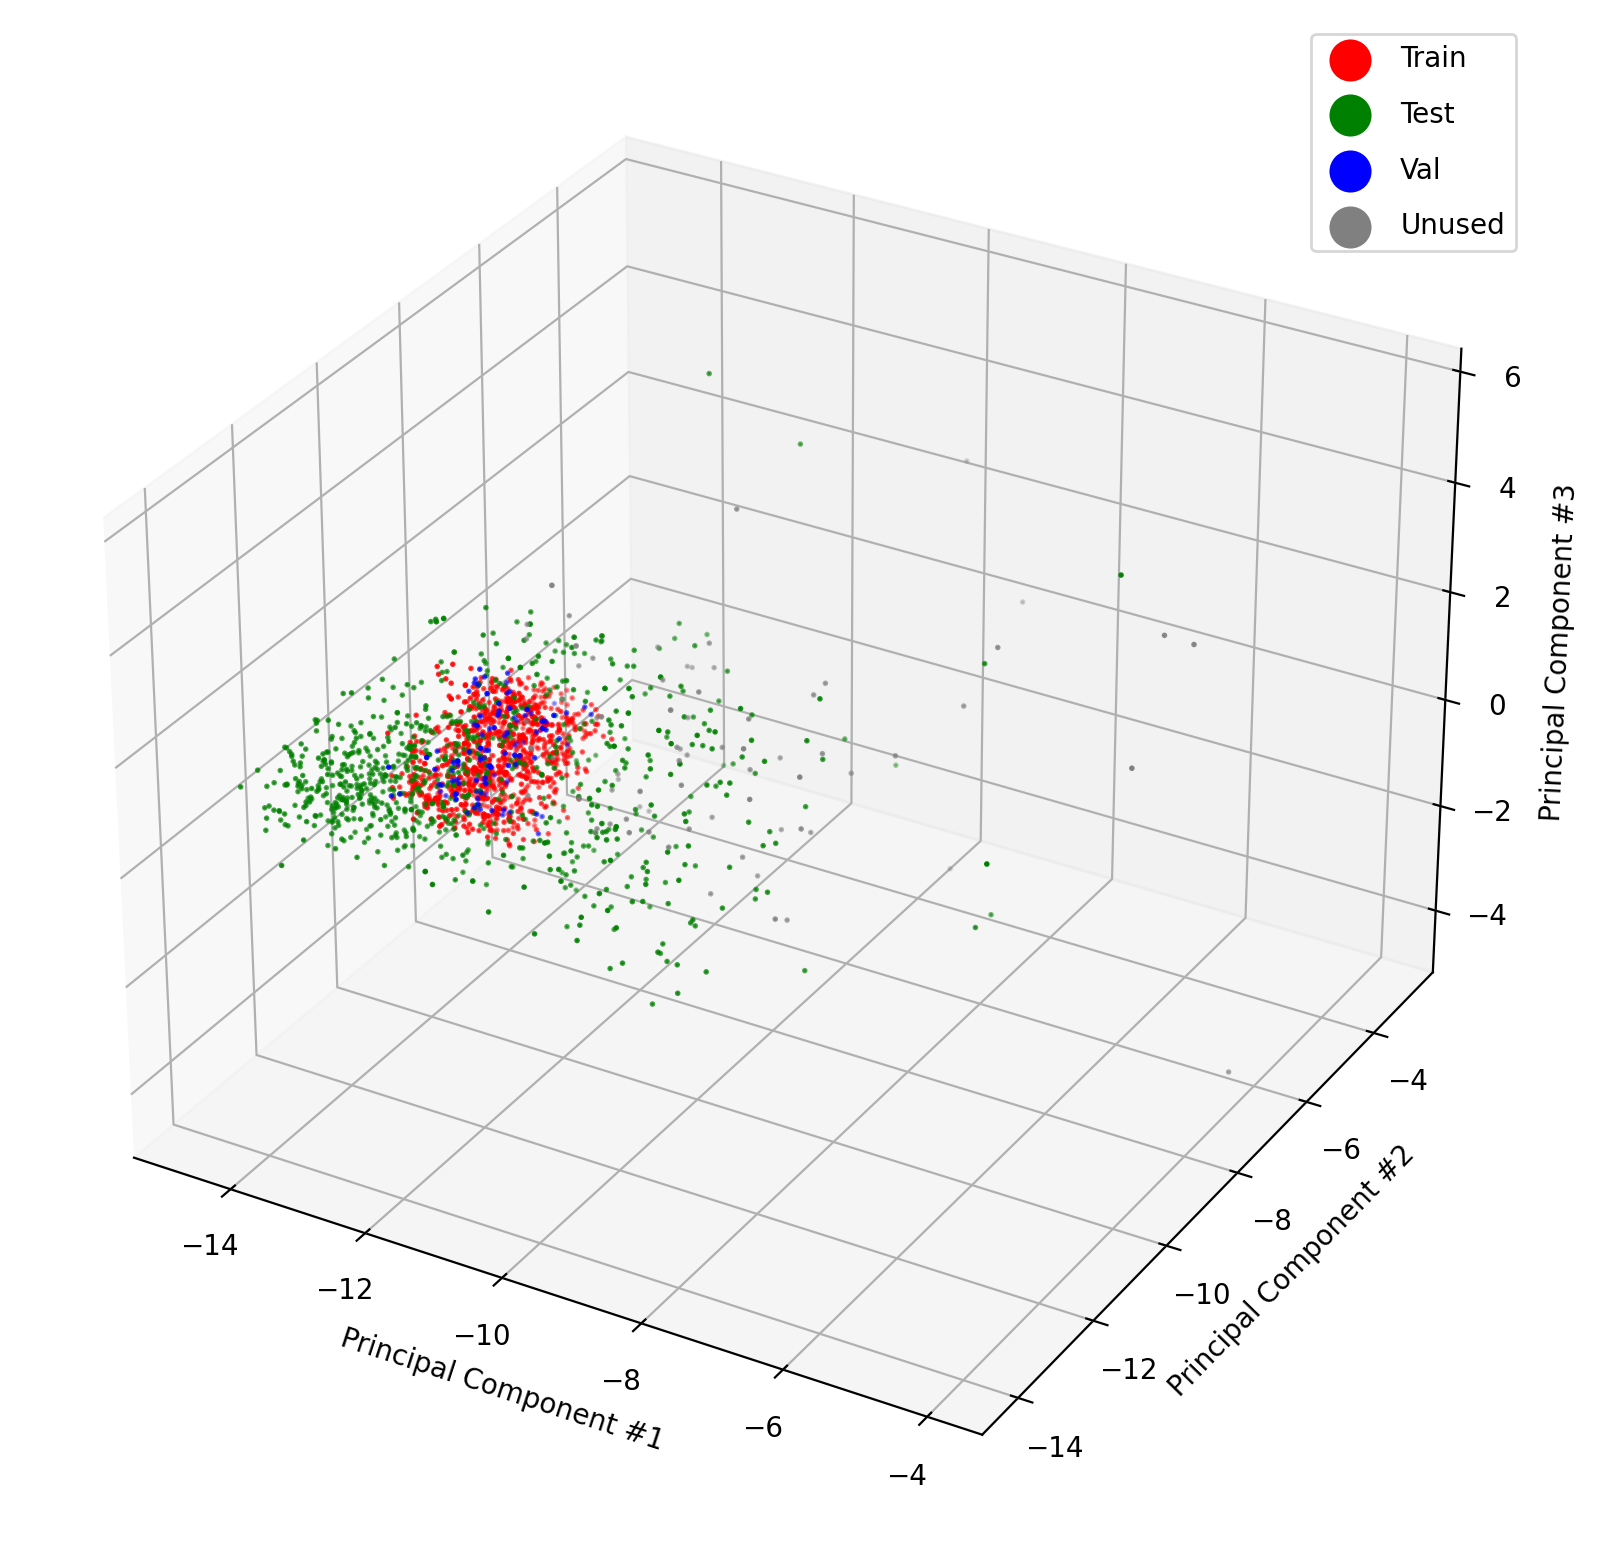

In [21]:
ood_lims_in = [[0., 3.], [0., 3.], [0., 3.], [0., 5.], [0., 5.], [0., 5.]]
train_lims_all = [[3., 10], [3., 10], [3., 10], [5., 10], [5., 10], [5., 10]]
ood_lims_out = [[10, 25], [10, 25], [10, 30], [10, 12], [10, 12], [10, 12]]

TRAIN, VAL, TEST = pre.split_by_bounds(df=df_orig,
                                 x_cols=x_cols,
                                 y_cols=y_cols,
                                 train_lims_all=train_lims_all,
                                 ood_lims_in=ood_lims_in,
                                 ood_lims_out=ood_lims_out,
                                 data_mean=data_mean, 
                                 data_std=data_std, 
                                 PCA_components=components,
                                 val_split=0.1,
                                 verbose=True,
                                 plots=True,
                                 figsize=(10,10))#,
                                      #save_image=True, savename="../reports/final_report_images/splitting_data/manual_bounds.eps", saveformat="eps")

x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

y_train_unnorm = pre.unnormalise(y_train,data_mean[y_cols].values,data_std[y_cols].values)
y_val_unnorm = pre.unnormalise(y_val,data_mean[y_cols].values,data_std[y_cols].values)
y_test_unnorm = pre.unnormalise(y_test,data_mean[y_cols].values,data_std[y_cols].values)


# Neural Network Instantiation and Training

## Define Parameters of the Model

In [22]:
# Save the model so we can load it and perform inference later
#savename = "../trained_models/for_prediction/MC_35"
#checkpoint_path = "../../trained_models/for_retraining/SGLD"

# Define the wandb parameters
parameters = dict(
    # Specific to this method
    noise_multiplier=1,
    anneal_gamma = None,
    burnin_epochs=250,
    num_networks=150,
    
    # Generic Hyperparameters
    num_epochs= 1000,
    batch_size= 50,# len(train_data), # Batch size for training data
    lr=  1e-3,                   # Learning rate
    weight_decay= None,          # Weight decay
    
    # Model architecture
    input_dim= len(x_cols),      # Number of input neurons
    output_dim= len(y_cols),     # Number of output neurons
    num_units= 50,              # Number of neurons per hidden layer
    num_layers=4,
    
    # Data
    y_cols = y_cols,             # Which column(s) contain the dependent variable(s) / label(s) 
    x_cols = x_cols,             # Which column(s) contain the independent variable(s) / feature(s)
    
    # Logigng only
    component = None,       # Which parameter are we sorting by (as an int)? 
    sortby=None,       # Name of the component we're sorting by (as a string)
    model_name= "SGLD_multiple_outputs",    # For logging only
    criterion_name= "MSELoss",   # For logging only
    optimiser_name= "Adam",      # For logging only 
    cutoff_percentile = None,  # How much we're splitting from top and bottom of sorted training set for test set 
    val_split=None,         # How much we're splitting from the train set (minus the test set), as a float between 0-1
    seed=seed,                   # Random seed used (for logging only)
)

assert parameters['output_dim'] == len(y_cols), f"Please ensure that the number of output neurons is correct! There should be {len(y_cols)}"
assert parameters['input_dim'] == len(x_cols), f"Please ensure that the number of input neurons is correct! There should be {len(x_cols)}" 

## If using Weights and Biases API, Log In

In [23]:
# Whether or not to log the run to Weights and Biases (https://wandb.ai/home). Requires an account
wandb_mode = True

if wandb_mode: 
    import wandb
    wandb.login()
    wandb.init(config=parameters, entity="archieluxton", project=parameters['model_name'])

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


loss,█▃▄▃▃▄▃▃▂▂▂▃▃▂▄▂▂▃▂▂▁▁▃▂▂▂▂▁▁▂▂▂▂▂▁▁▂▁▃▁
val_loss,█▅▄▃▄▂▃▃▂▄▂▃▃▂▃▂▆▅▃▂▁▄▂▃▂▂▃▁▂▄▂▄▃▃▂▂▂▁▁▂
loss,0.00287
val_loss,0.00356


## Instantiate the Model Class

In [24]:
# Instantiate a model class of type MC Dropout
model = SG.SGLD(train_data = train_data,
                              parameters=parameters, 
                              val_data=val_data,
                              data_mean=data_mean,
                              data_std=data_std,
                              wandb_mode=wandb_mode)

## Train the Model

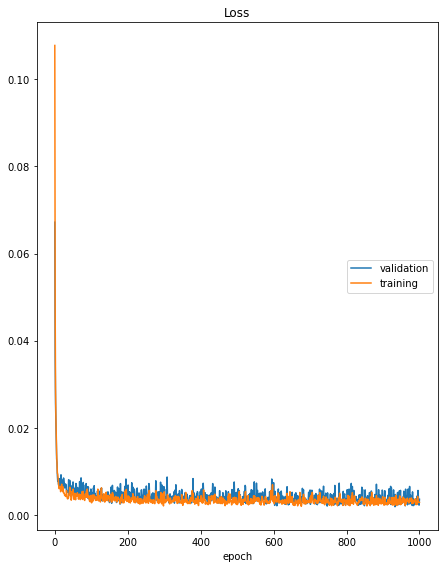

Loss
	validation       	 (min:    0.002, max:    0.067, cur:    0.004)
	training         	 (min:    0.002, max:    0.108, cur:    0.003)
Time elapsed: 446.95s.
Number of trainable model parameters: 5552, number of training samples: 929
Used batches of 50.

Time taken: 447.0081443786621s


In [25]:
start = time.time()

net, train_loss, val_loss = model.train_model()

end = time.time()
print(f"Time taken: {end-start}s")

# Perform Forward Passes for each Dataset

In [26]:
samples_train, means_train, stds_train, y_train_np = model.run_sampling(x_train, y_train)
samples_test, means_test, stds_test, y_test_np = model.run_sampling(x_test, y_test)             
samples_val, means_val, stds_val, y_val_np = model.run_sampling(x_val, y_val)

***
***
# Post-Processing and Visualisation

## Count number of 'untrustworthy' predictions
This function checks how many of the true values in each dataset (test, train, val) fall outside the confidence interval.

It does *not* tell us how accurate the mean predictions are.

In [27]:
err_train0 = post.count_wrong_preds(samples_train[0], y_train_np[0], 1, "SD", False)
err_test0 = post.count_wrong_preds(samples_test[0], y_test_np[0], 1, "SD", False)
err_val0 = post.count_wrong_preds(samples_val[0], y_val_np[0], 1, "SD", False)

print(f"Untrustworthy in train:\t{np.sum(err_train0)}\t(low: {err_train0[0]}, high: {err_train0[1]})")
print(f"Untrustworthy in test:\t{np.sum(err_test0)}\t(low: {err_test0[0]}, high: {err_test0[1]})")
print(f"Untrustworthy in val:\t{np.sum(err_val0)}\t(low: {err_val0[0]}, high: {err_val0[1]})")
print("----------------------")
print(f"Total untrustworthy:\t{np.sum(err_train0)+np.sum(err_test0)+np.sum(err_val0)}")

Untrustworthy in train:	0	(low: 0, high: 0)
Untrustworthy in test:	588	(low: 509, high: 79)
Untrustworthy in val:	1	(low: 1, high: 0)
----------------------
Total untrustworthy:	589


In [28]:
err_train1 = post.count_wrong_preds(samples_train[1], y_train_np[1], 1, "SD", False)
err_test1 = post.count_wrong_preds(samples_test[1], y_test_np[1], 1, "SD", False)
err_val1 = post.count_wrong_preds(samples_val[1], y_val_np[1], 1, "SD", False)

print(f"Untrustworthy in train:\t{np.sum(err_train1)}\t(low: {err_train1[0]}, high: {err_train1[1]})")
print(f"Untrustworthy in test:\t{np.sum(err_test1)}\t(low: {err_test1[0]}, high: {err_test1[1]})")
print(f"Untrustworthy in val:\t{np.sum(err_val1)}\t(low: {err_val1[0]}, high: {err_val1[1]})")
print("----------------------")
print(f"Total untrustworthy:\t{np.sum(err_train1)+np.sum(err_test1)+np.sum(err_val1)}")

Untrustworthy in train:	0	(low: 0, high: 0)
Untrustworthy in test:	563	(low: 522, high: 41)
Untrustworthy in val:	1	(low: 1, high: 0)
----------------------
Total untrustworthy:	564


## Plot the Uncertainty of Each Datapoint (Train, Test and Val)

The plot below shows us intuitively what the accuracy and uncertainty of predictions in each dataset is. From this, it's clear to see that the prediction accuracy is high in the training and validation set, and both the accuracy and certainty in the test set are low as expected. 

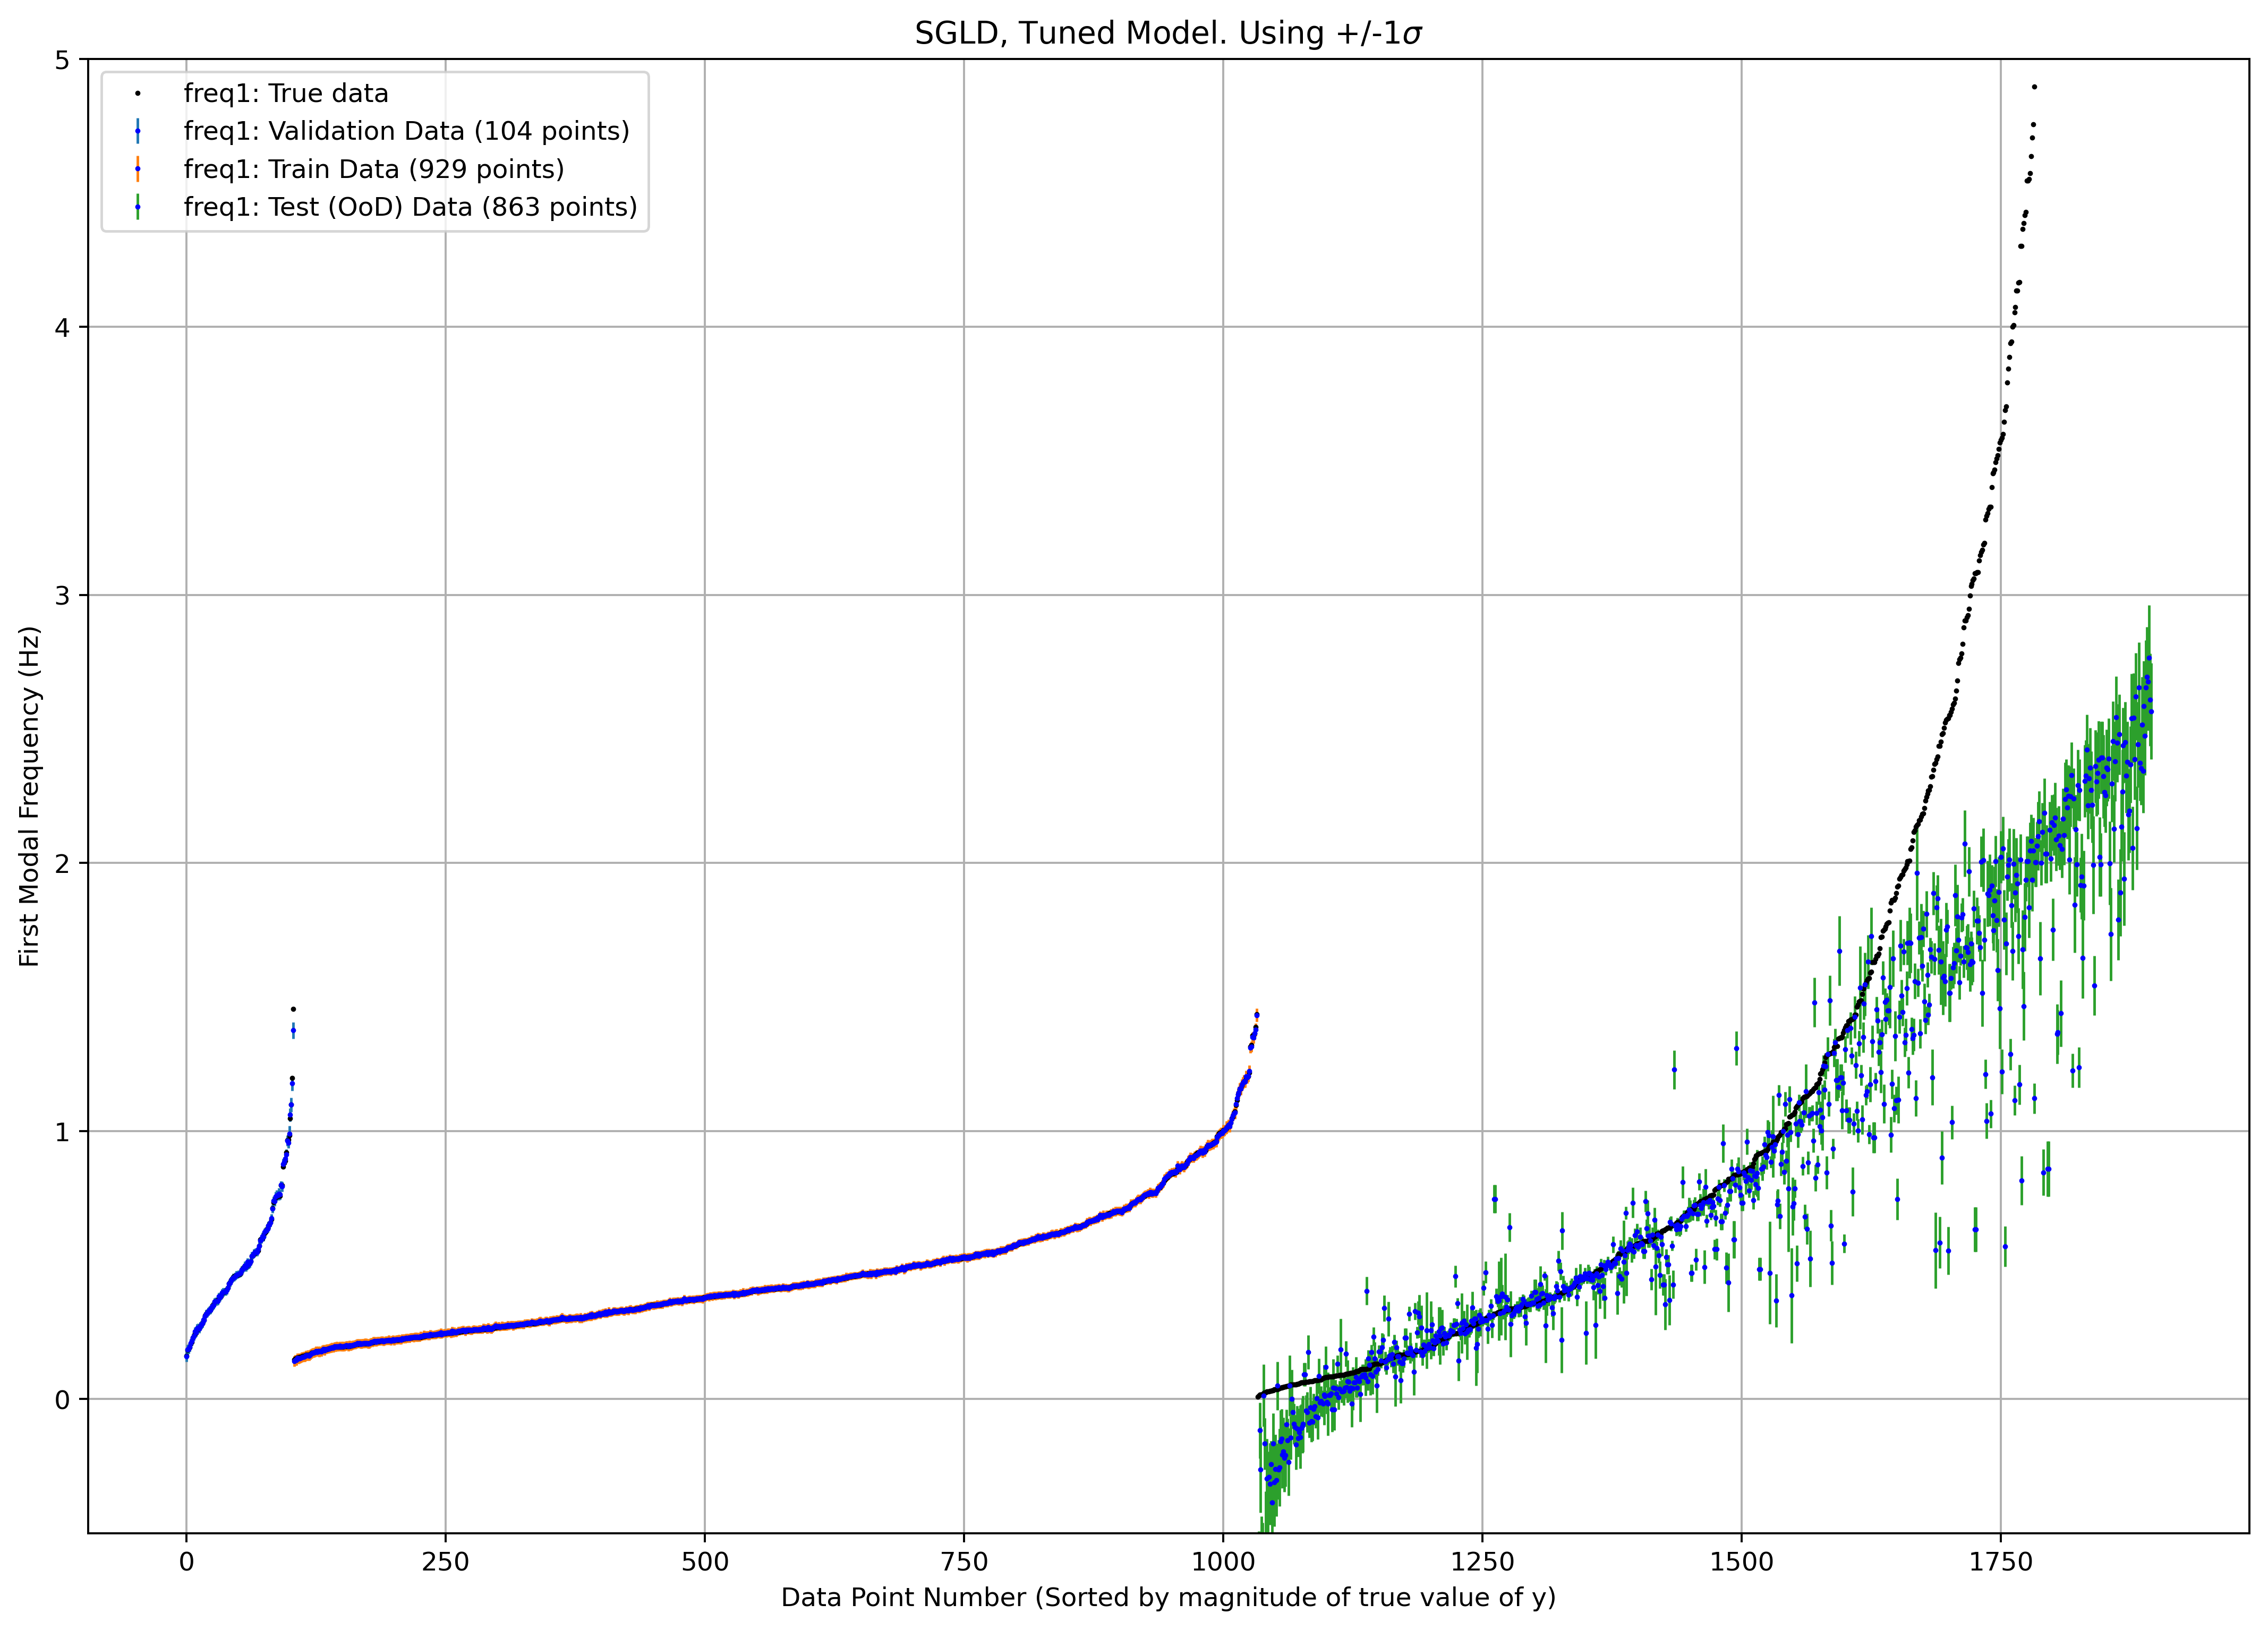

In [29]:
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=0,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = parameters["component"],
             sort=True,
             sortby="0",
             bar_method="bars",
             title="SGLD, Tuned Model",
             ylabel="First Modal Frequency (Hz)",
              figsize=(15,10.5),
             ylim=(-0.5,5))

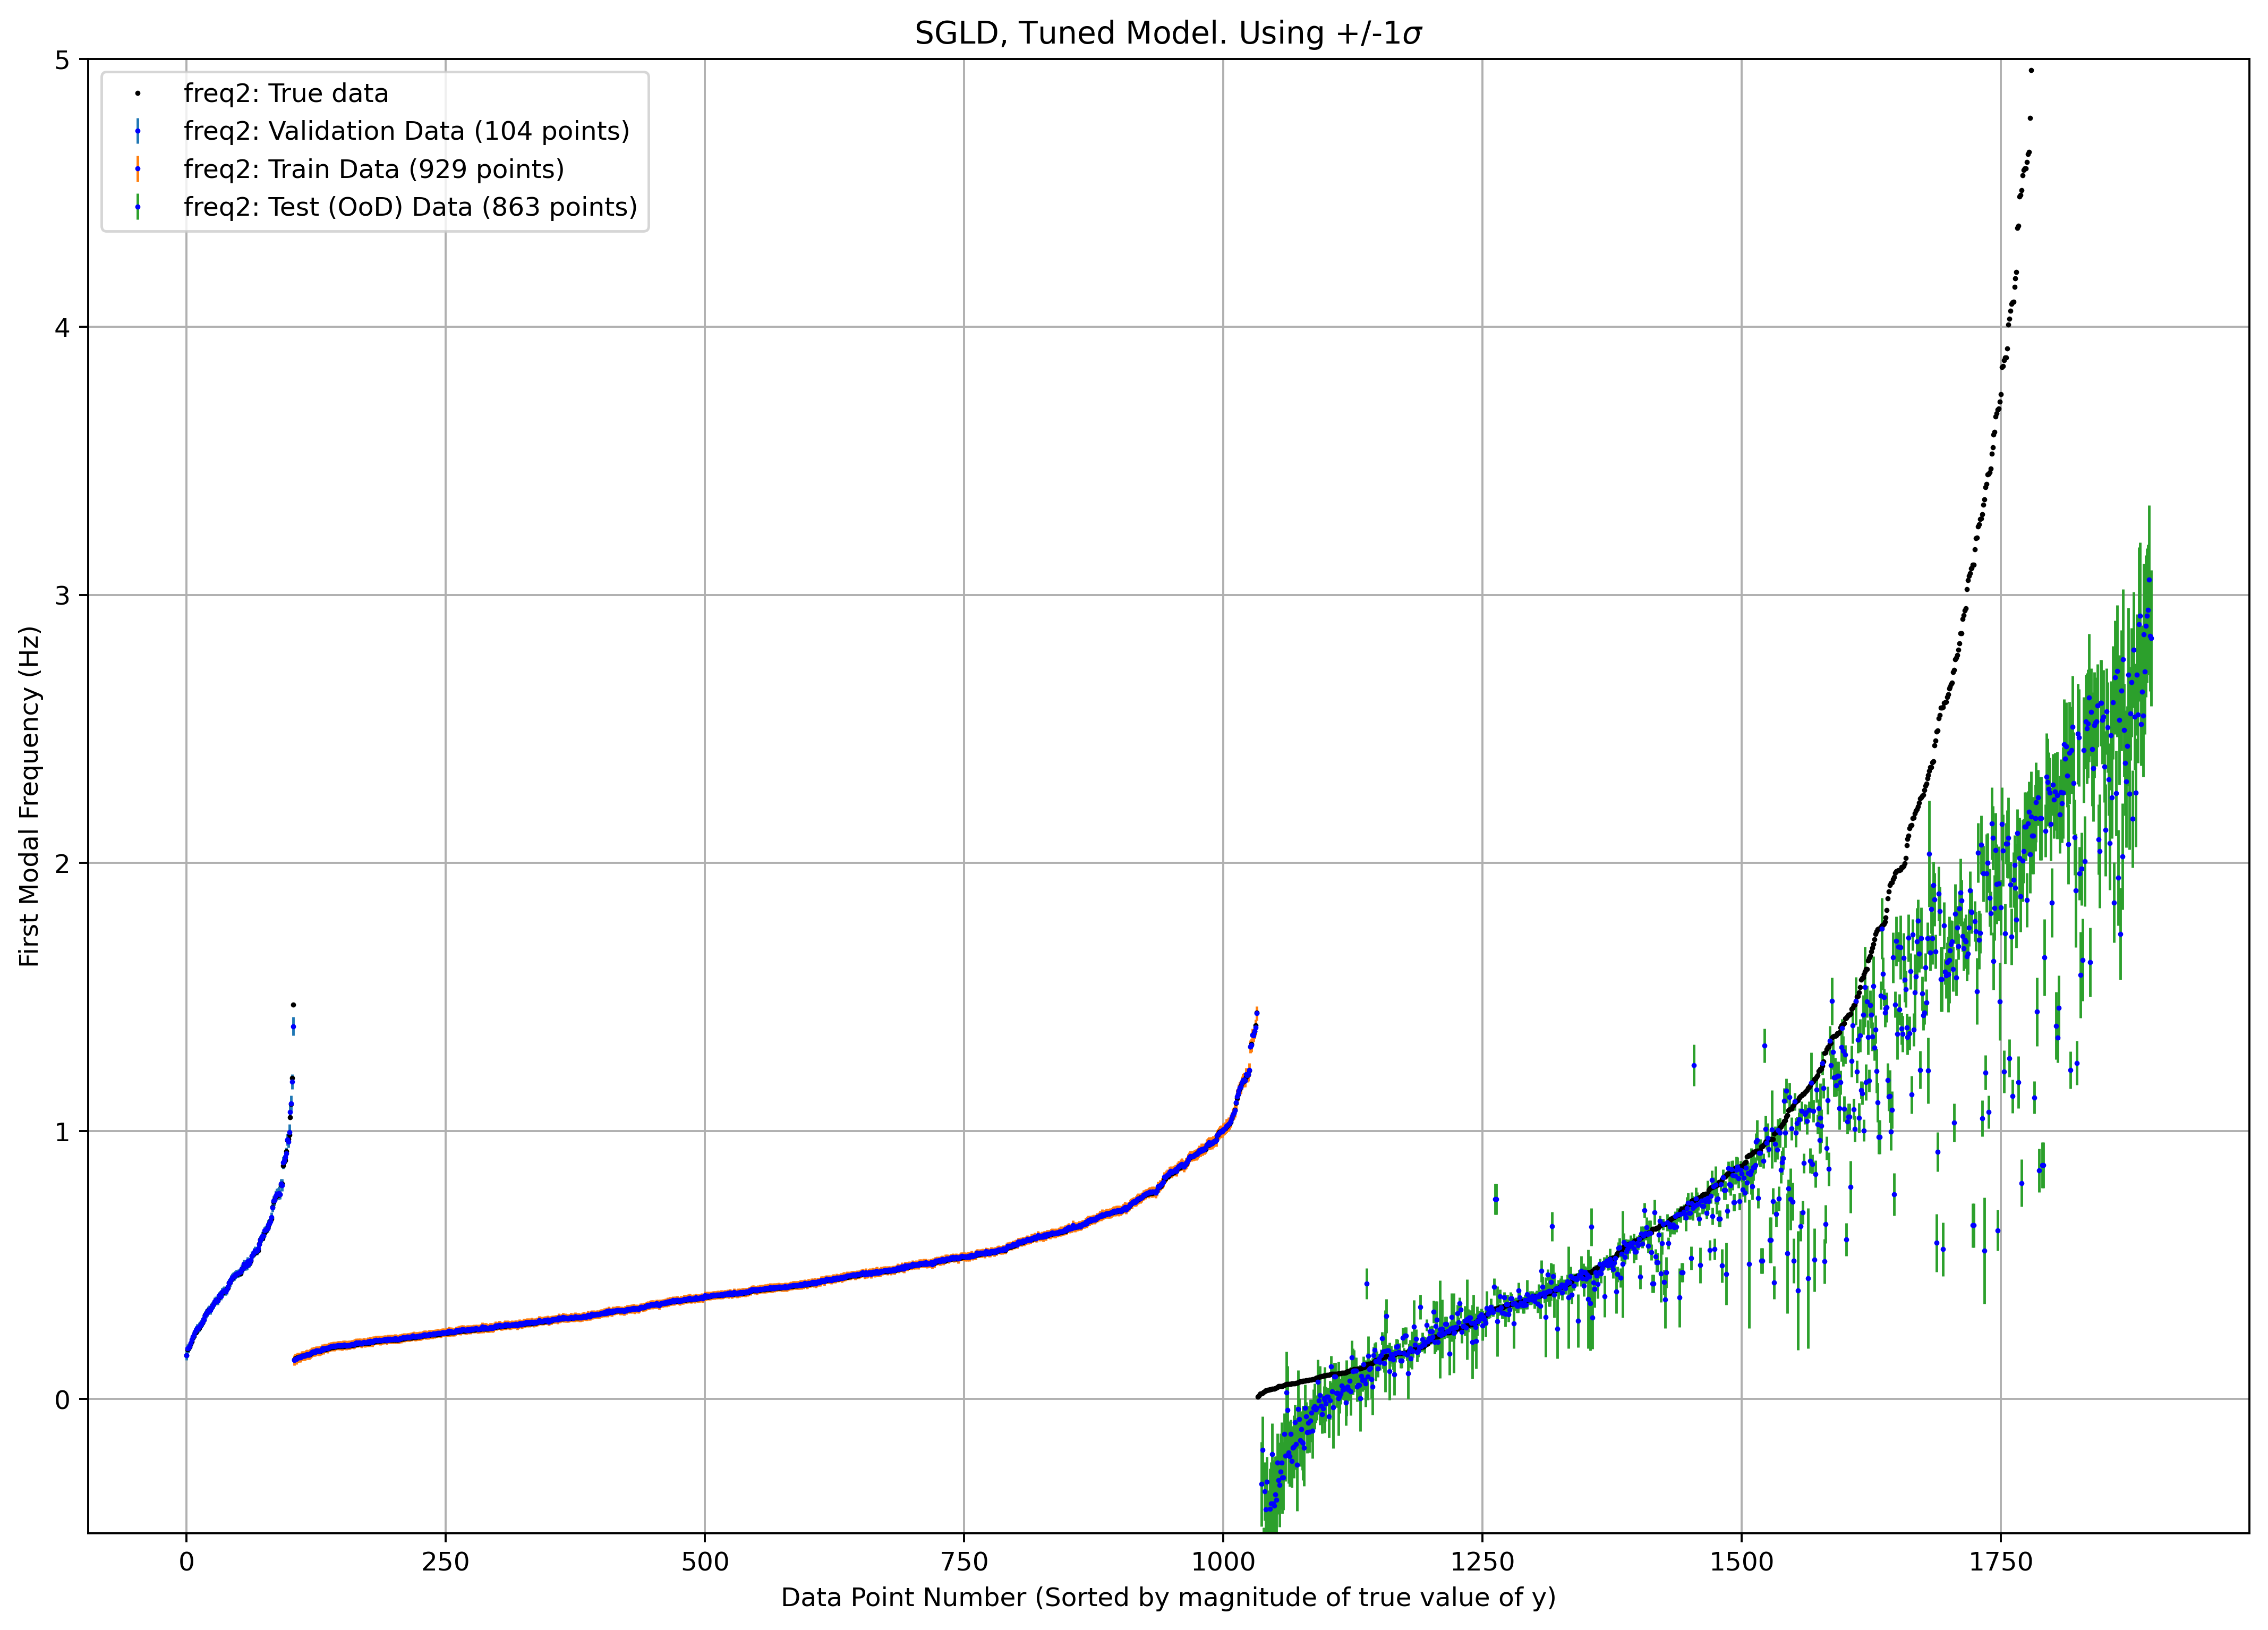

In [30]:
uncert_plot = post.result_plots(all_samples = [samples_val, samples_train, samples_test],
             labels = ["Validation", "Train", "Test (OoD)"],
             output_labels = ["freq1", "freq2"],
             all_true = [y_val_np, y_train_np, y_test_np],
             output_num=1,
             #true_inds = [val_indices, train_indices, test_indices],
             interval = 1,
             method="SD",
             component_name = parameters["component"],
             sort=True,
             sortby="0",
             bar_method="bars",
             title="SGLD, Tuned Model",
             ylabel="First Modal Frequency (Hz)",
              figsize=(15,10.5),
             ylim=(-0.5,5))

### Ridgeline Plot

This visualises the distribution for each point prediction made. Every eighth datapoint is omitted for clarity of the plot.

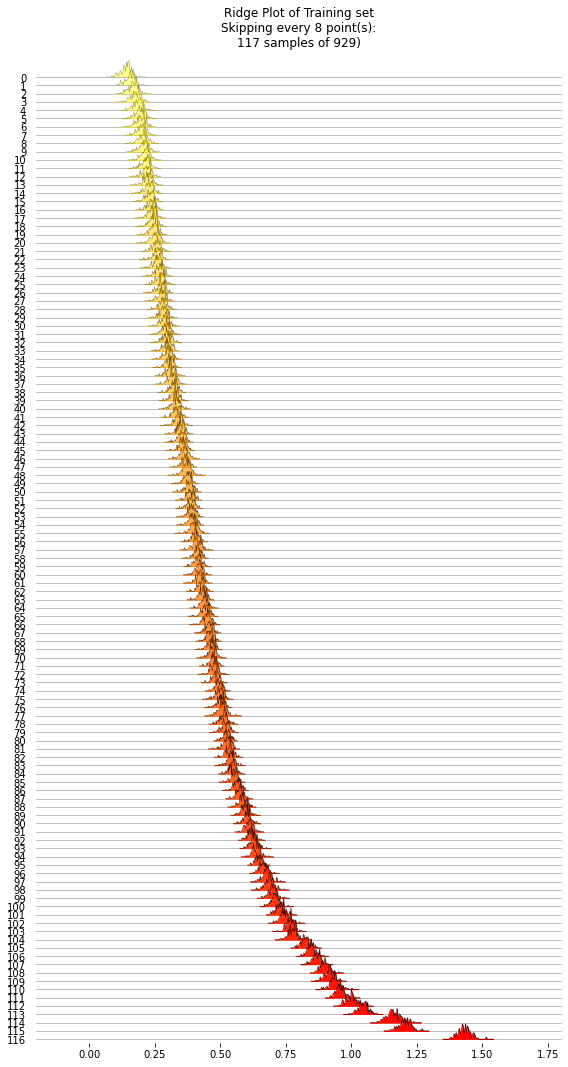

In [31]:
import joypy
from matplotlib import cm

%matplotlib inline
means_train2, samples_train2, stds_train2 = post.sort_data([means_train[0], samples_train[0], stds_train[0]],sortby=0) 
skip_every = 8
data = pd.DataFrame(samples_train2.squeeze()[:,::skip_every])

fig, axes = joypy.joyplot(pd.DataFrame(samples_train2.squeeze()[:,::skip_every]),
                          range_style='own', # Limits each subplot to the area where it's non-zero
                          #ylabels=False,   # Also turns off horz grid lines if False
                          #xlabels=True,
                          overlap=0.5,        
                          grid='y',        # 'y': Horz grid lines, True: horz and vert
                          linewidth=0.5,     # Outlines
                          #labels = labels,   # Which y labels to plot (corresponding to horz lines). Doesn't work for some reason
                          kind='counts',   # Plotting raw counts rather than estimated density
                          #legend=True,   
                          figsize=(8,15),
                          bins=50, 
                          fade=True,       # subplots get progressively higher alpha values 
                          title=f"Ridge Plot of Training set\nSkipping every {skip_every} point(s):\n{data.shape[1]} samples of {len(means_train[0])})",
                          colormap=cm.autumn_r);

## Show the Distribution of Errors and Uncertainties in each Dataset
### Using Histograms

These plots make a range of summaries about the dataset and predictions.

In row major ordering:

 - Plot 1: The error between each prediction sample and the true value. This outlines the accuracy of the predictions, and the spread of the samples.  
 - Plot 2: Very similar to Plot 1, except looking at the mean of all samples drawn for each datapoint. This outlines the accuracy of the predictions. 
 - Plot 3: Shows the absolute width of the confidence interval of every data point in each set. This outlines the uncertainty of the predictions.  
 - Plot 4: Shows the distribution of the predicted values in each dataset. This outlines the performance of the model as well as describing the dataset.
 - Plot 5: If a confidence interval does not capture the true y value, then how far outside the confidence interval is the y value?

C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, =

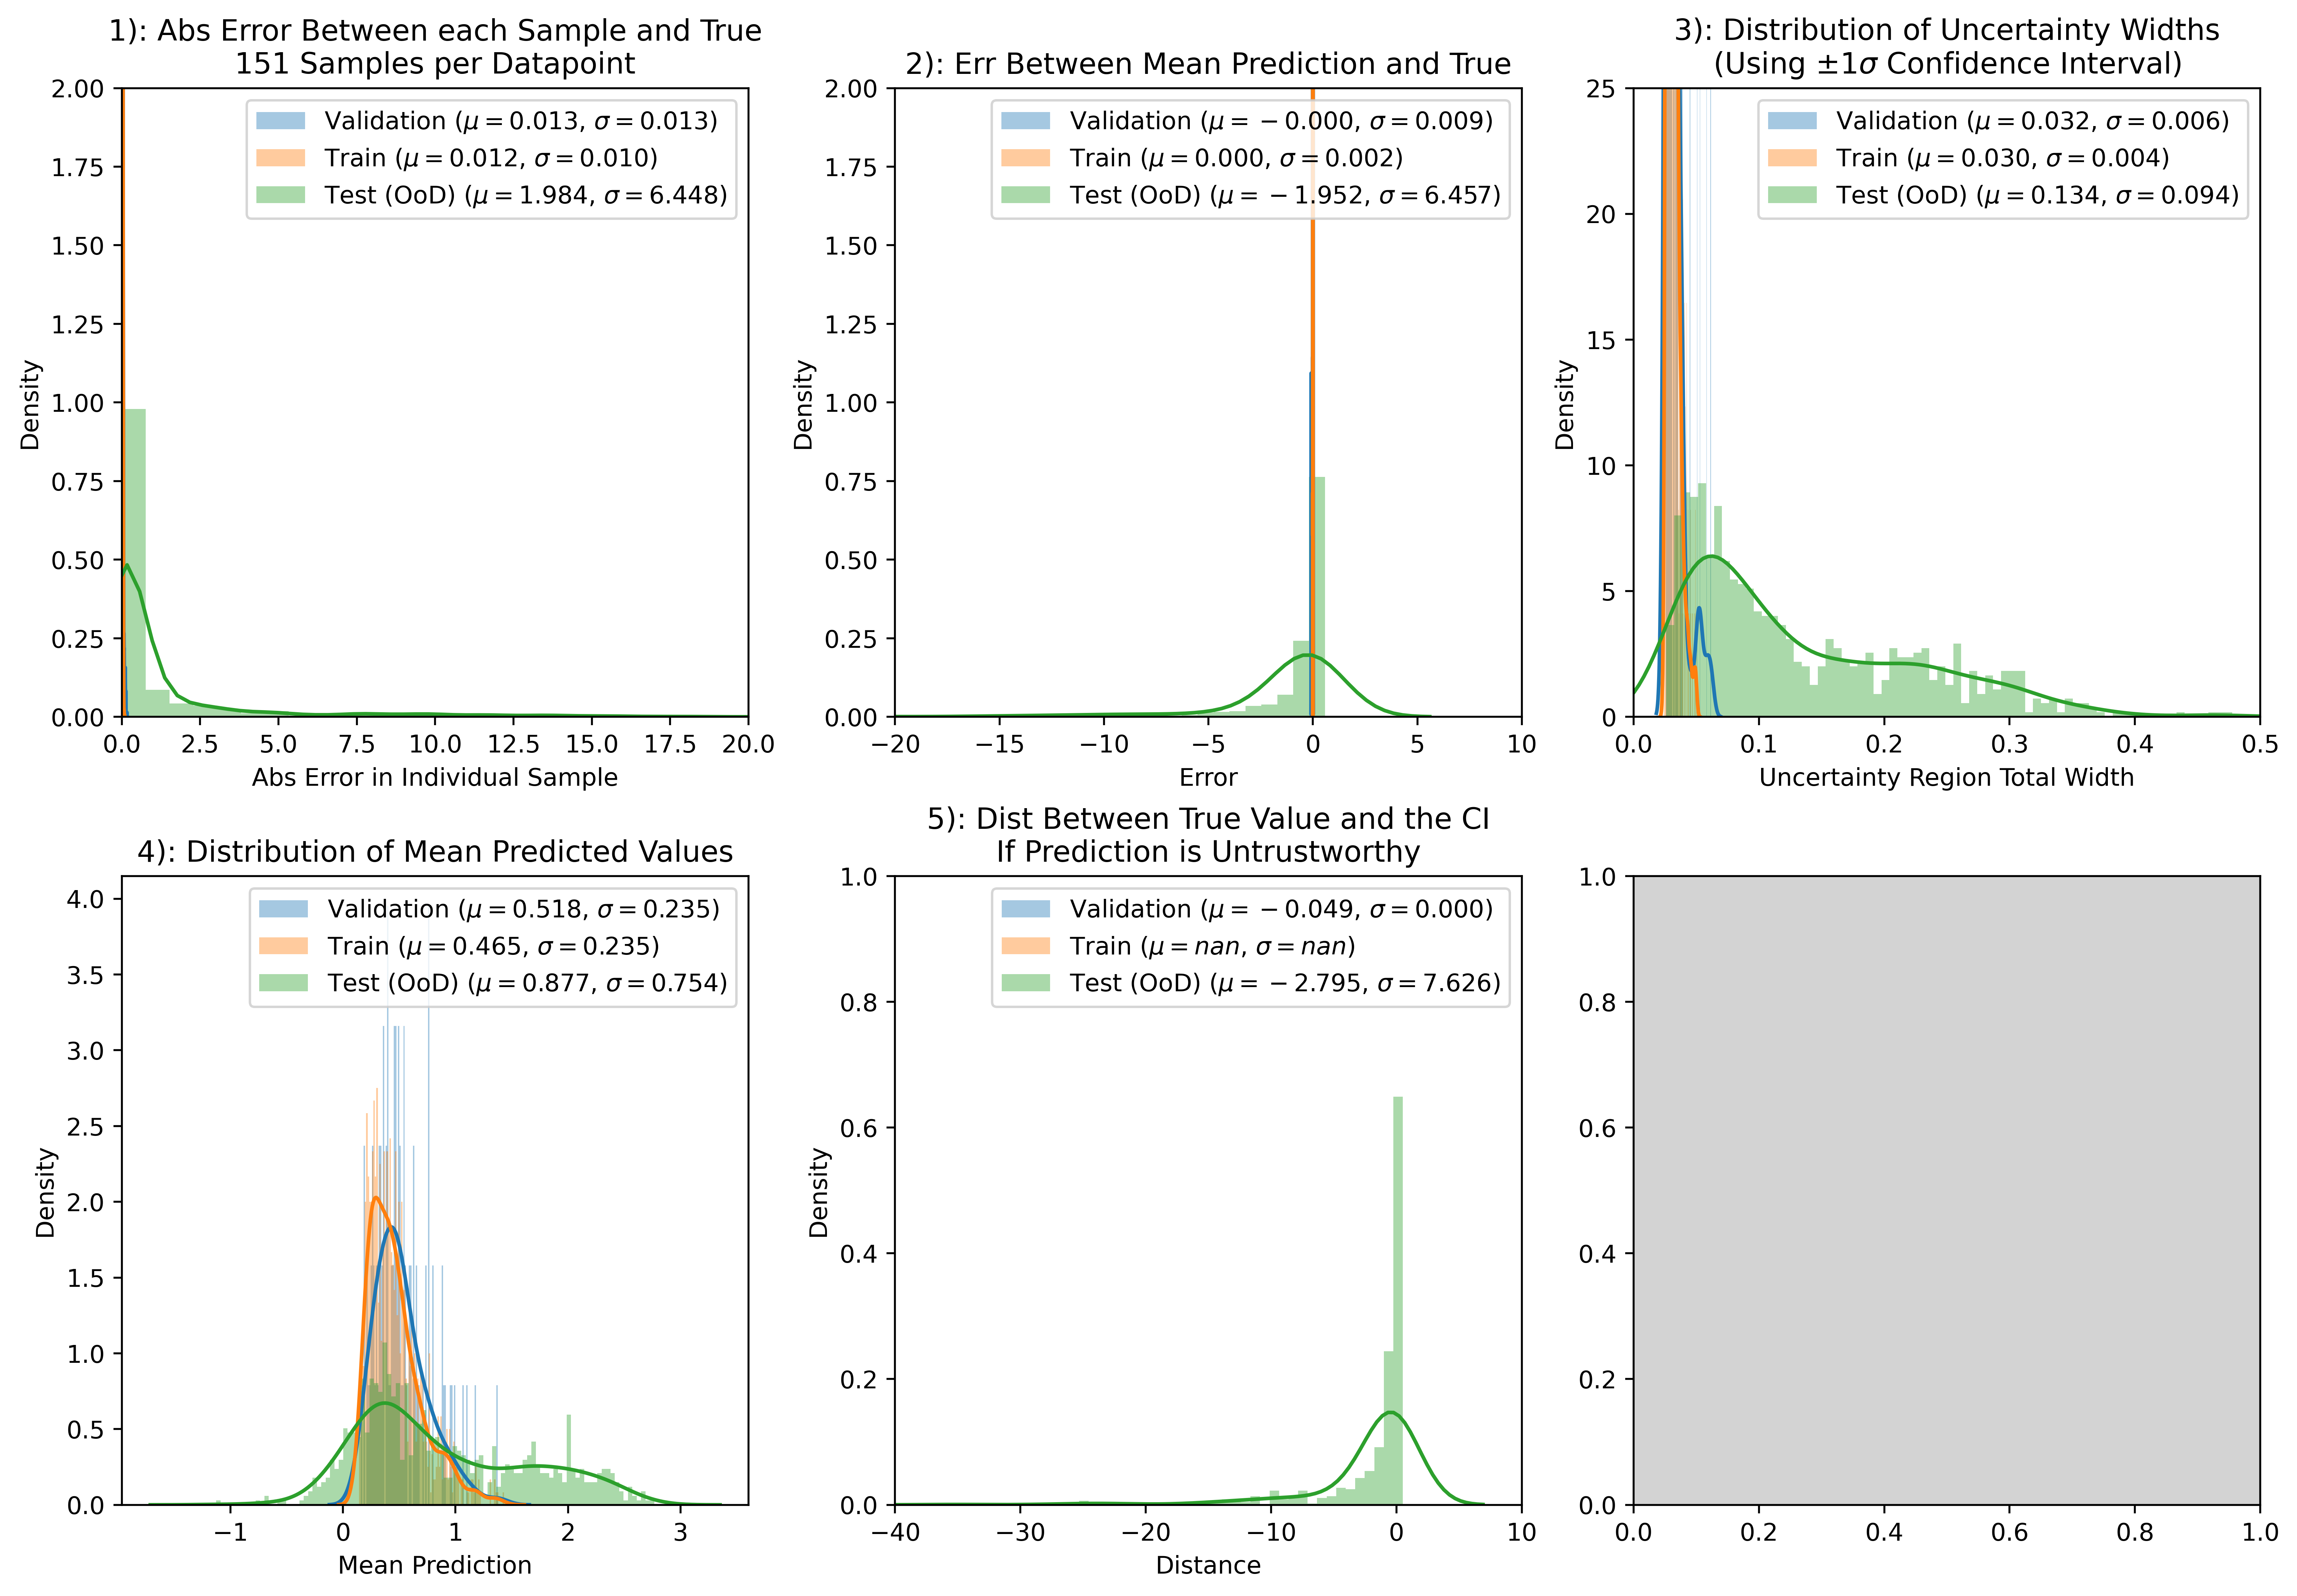

In [32]:
%matplotlib inline
samples = [samples_val[0], samples_train[0], samples_test[0]]
true = [y_val_np[0], y_train_np[0], y_test_np[0]]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples,
                                                true,
                                                labels,
                                                method="SD",
                                                interval=1,
                                                dp=.3,
                                                bins=100,
                                                figsize=(13,9),
                                                plot_1_ylim=(0,2),
                                                plot_1_xlim=(0,20),
                                                plot_2_ylim=(0,2),
                                                plot_3_ylim=(0,25),
                                                plot_3_xlim=(0,0.5),
                                                plot_2_xlim=(-20,10),
                                                plot_5_ylim=(0,1),
                                                plot_5_xlim=(-40,10))
                                                

# Save the image to weights and biases
if wandb_mode: wandb.log({"Histograms_output0":wandb.Image(histograms1)})
if wandb_mode: wandb.log({"Data_output0":statistics1})
    
    
# Print the individual figures shown in the histograms
# import json
# print(json.dumps(statistics1, indent=6, default=str))

C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, =

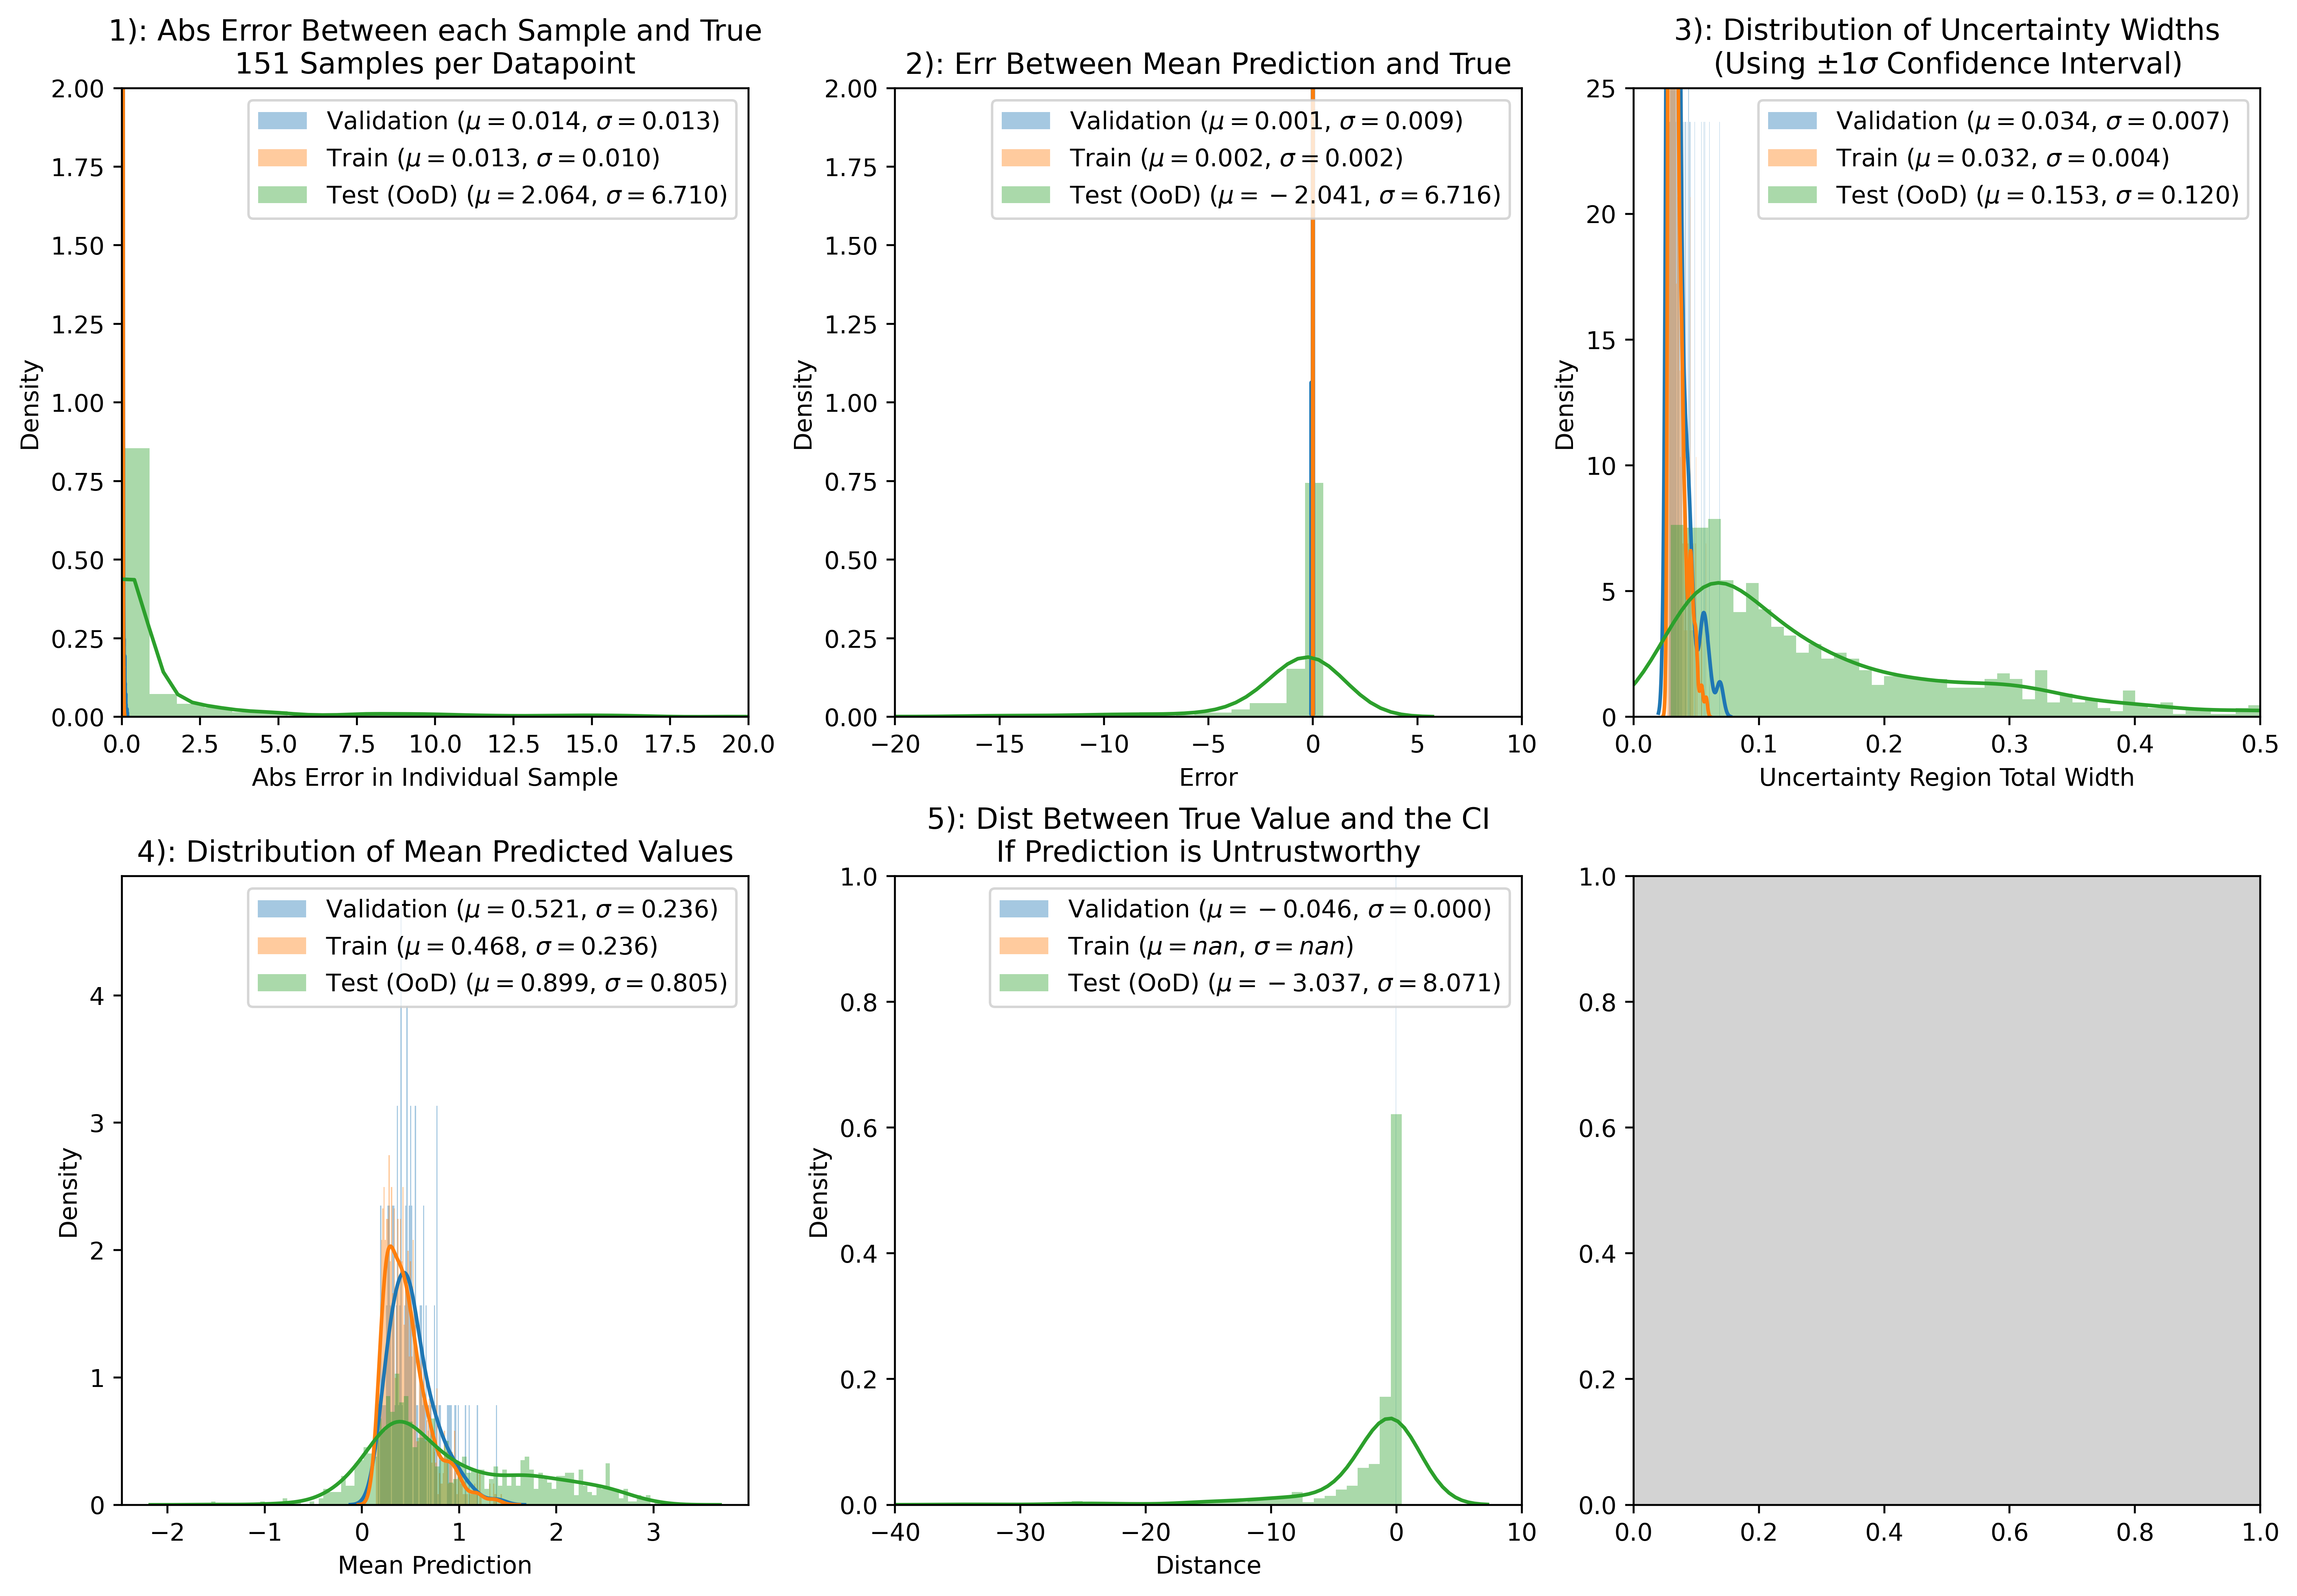

In [33]:
%matplotlib inline
samples = [samples_val[1], samples_train[1], samples_test[1]]
true = [y_val_np[1], y_train_np[1], y_test_np[1]]
labels=["Validation", "Train", "Test (OoD)"]
histograms1, statistics1 = post.histogram_stats(samples,
                                                true,
                                                labels,
                                                method="SD",
                                                interval=1,
                                                dp=.3,
                                                bins=100,
                                                figsize=(13,9),
                                                plot_1_ylim=(0,2),
                                                plot_1_xlim=(0,20),
                                                plot_2_ylim=(0,2),
                                                plot_3_ylim=(0,25),
                                                plot_3_xlim=(0,0.5),
                                                plot_2_xlim=(-20,10),
                                                plot_5_ylim=(0,1),
                                                plot_5_xlim=(-40,10))
                                                

# Save the image to weights and biases
if wandb_mode: wandb.log({"Histograms_output0":wandb.Image(histograms1)})
if wandb_mode: wandb.log({"Data_output0":statistics1})
    
    
# Print the individual figures shown in the histograms
# import json
# print(json.dumps(statistics1, indent=6, default=str))

# Save Model State

In [34]:
#torch.save(model, savename)